## ```ROBUSTNESS ```

In [16]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import multi_agents_tools  as mat
import pandas as pd
import numpy as np
import json
from utils import plot_results, count_values
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import defaultdict
print(tf.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.20.0


### ```TESTS```

In [2]:
# Script de test
name_data='mnist'
x_train, y_train, x_test, y_test = mat.get_data(name_data)
print(f"1. get_data: {y_train.dtype}")  # int32

groups_x, groups_y = mat.split_dataset_fully_synchronized(x_train, y_train, num_groups=3)
print(f"2. split: {groups_y[0].dtype}")  # int32

train_datasets = mat.make_tf_datasets_from_groups(groups_x, groups_y, batch_size=100)
for x, y in train_datasets[0].take(1):
    print(f"3. dataset: {y.dtype}")  # devrait être int32

del groups_x,groups_y


1. get_data: int32
2. split: int32
3. dataset: <dtype: 'int32'>


In [3]:
# Test dans cross_information
multi_agent = mat.MultiAgentAI(k=3)
for batches in zip(*train_datasets):
    x_batch_list = [b[0] for b in batches]
    y_batch_list = [b[1] for b in batches]
    print(f"4. batch labels: {y_batch_list[0].dtype}")  # int32
    losses, outputs = multi_agent.train_step_batch(x_batch_list, y_batch_list)
    print(f"5. Entraînement OK!")
    break
del losses,outputs,train_datasets

✓ CPU détecté - Optimisateur: ADAMW
4. batch labels: <dtype: 'int32'>
5. Entraînement OK!


```TRAIN MULTI AGENTS```

In [4]:
K=7
batch_size=100
input_dim = 784
hidden_dim = K*150
output_dim = 10
lr = 0.001
epochs = 10
verbose=False

In [5]:
train_groups_x, train_groups_y = mat.split_dataset_fully_synchronized(x_train, y_train,num_groups=K)
test_groups_x, test_groups_y = mat.split_dataset_fully_synchronized(x_test, y_test,num_groups=K)

In [6]:
train_datasets = mat.make_tf_datasets_from_groups(train_groups_x, train_groups_y, batch_size=batch_size, shuffle=False)
test_datasets = mat.make_tf_datasets_from_groups(test_groups_x, test_groups_y, batch_size=batch_size, shuffle=False)


In [7]:
mat.verify_batch_synchronization(train_datasets)

True

In [10]:
model=mat.MultiAgentAI(k=K, hidden_size=int(hidden_dim/K), lr=lr, input_shape=None,num_classes=10,  optimizer_type='adamw',batch_size=batch_size)

✓ CPU détecté - Optimisateur: ADAMW


In [11]:
history=model.train_step(train_datasets=train_datasets,epochs=epochs, test_datasets=test_datasets,strategy='majority',verbose=True,alpha=1, beta=0)


Epoch 1/10
  Agent 1 - Loss: 1.8257, Acc: 0.7495
  Agent 2 - Loss: 1.7115, Acc: 0.7700
  Agent 3 - Loss: 1.8062, Acc: 0.7548
  Agent 4 - Loss: 1.7365, Acc: 0.7623
  Agent 5 - Loss: 1.6031, Acc: 0.7790
  Agent 6 - Loss: 1.6509, Acc: 0.7724
  Agent 7 - Loss: 1.7423, Acc: 0.7616
  Ensemble Test Accuracy: 1.0000

Epoch 2/10
  Agent 1 - Loss: 0.3303, Acc: 0.8953
  Agent 2 - Loss: 0.3268, Acc: 0.8982
  Agent 3 - Loss: 0.3634, Acc: 0.8871
  Agent 4 - Loss: 0.3201, Acc: 0.8977
  Agent 5 - Loss: 0.3097, Acc: 0.9006
  Agent 6 - Loss: 0.3392, Acc: 0.8917
  Agent 7 - Loss: 0.3388, Acc: 0.8969
  Ensemble Test Accuracy: 1.0000

Epoch 3/10
  Agent 1 - Loss: 0.2406, Acc: 0.9120
  Agent 2 - Loss: 0.2381, Acc: 0.9124
  Agent 3 - Loss: 0.2721, Acc: 0.9010
  Agent 4 - Loss: 0.2284, Acc: 0.9127
  Agent 5 - Loss: 0.2244, Acc: 0.9140
  Agent 6 - Loss: 0.2490, Acc: 0.9089
  Agent 7 - Loss: 0.2494, Acc: 0.9113
  Ensemble Test Accuracy: 1.0000

Epoch 4/10
  Agent 1 - Loss: 0.1957, Acc: 0.9202
  Agent 2 - Loss:

In [12]:
accuracy=model.evaluate_ensemble(test_datasets,strategy='majority',verbose=True)


Evaluation des agents :
  Agent 1 - Acc: 0.9256
  Agent 2 - Acc: 0.9200
  Agent 3 - Acc: 0.9088
  Agent 4 - Acc: 0.9347
  Agent 5 - Acc: 0.9228
  Agent 6 - Acc: 0.9439
  Agent 7 - Acc: 0.9319
  Ensemble (majority) - Acc: 1.0000


In [13]:
entropies = model.entropy_ensemble(test_datasets)

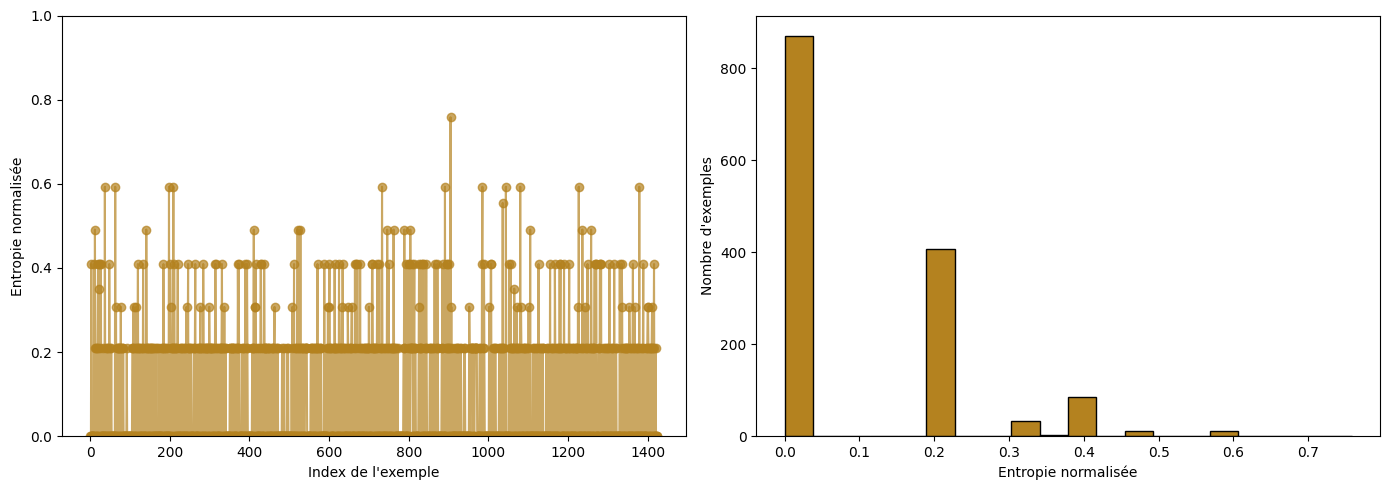

In [14]:
colors = ["#b4821f", "#155D26", "#2e2ca0", "#5f2e2e", "#9467bd"]
inv=0 if name_data in ['mnist'] else 1 if name_data in ['fashion_mnist'] else 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Ligne des entropies par exemple
axes[0].plot(entropies, marker='o', linestyle='-', alpha=0.7, color=colors[inv])
# axes[0].set_title("Entropie des prédictions par exemple")
axes[0].set_xlabel("Index de l'exemple")
axes[0].set_ylabel("Entropie normalisée")
axes[0].set_ylim(0, 1)
axes[0].grid(False)

# 2. Histogramme pour la distribution
axes[1].hist(entropies, bins=20, color=colors[inv], edgecolor='black')
# axes[1].set_title("Distribution des entropies")
axes[1].set_xlabel("Entropie normalisée")
axes[1].set_ylabel("Nombre d'exemples")
axes[1].grid(False)

plt.tight_layout()
# plt.savefig(f"Entropie_{name_data}.pdf", dpi=250, bbox_inches="tight")
plt.show()


In [17]:
count_values(entropies)

{-0.0: 871,
 0.4092232584953308: 86,
 0.49113261699676514: 2,
 0.21075810492038727: 407,
 0.3509453237056732: 2,
 0.59290611743927: 11,
 0.3074497580528259: 34,
 0.49113258719444275: 10,
 0.7580393552780151: 1,
 0.5544922947883606: 1}

In [18]:
entropies.shape

TensorShape([1425])

In [19]:
index={'epochs': [k for k in range(epochs)]}
losses={f'lossAI-{i}':history.get('losses')[i] for i in range(K)}
accuracies={f'accuracyAI-{i}': history.get('accuracies')[i] for i in range(K)}
ensemble_accuracy={f'majority': history.get('ensemble_accuracy')}

In [20]:
json_=defaultdict()

In [21]:
json_.update(index)
json_.update(losses)
json_.update(accuracies)
json_.update(ensemble_accuracy)

In [22]:
df=pd.DataFrame(json_)
df.set_index('epochs', inplace=True)

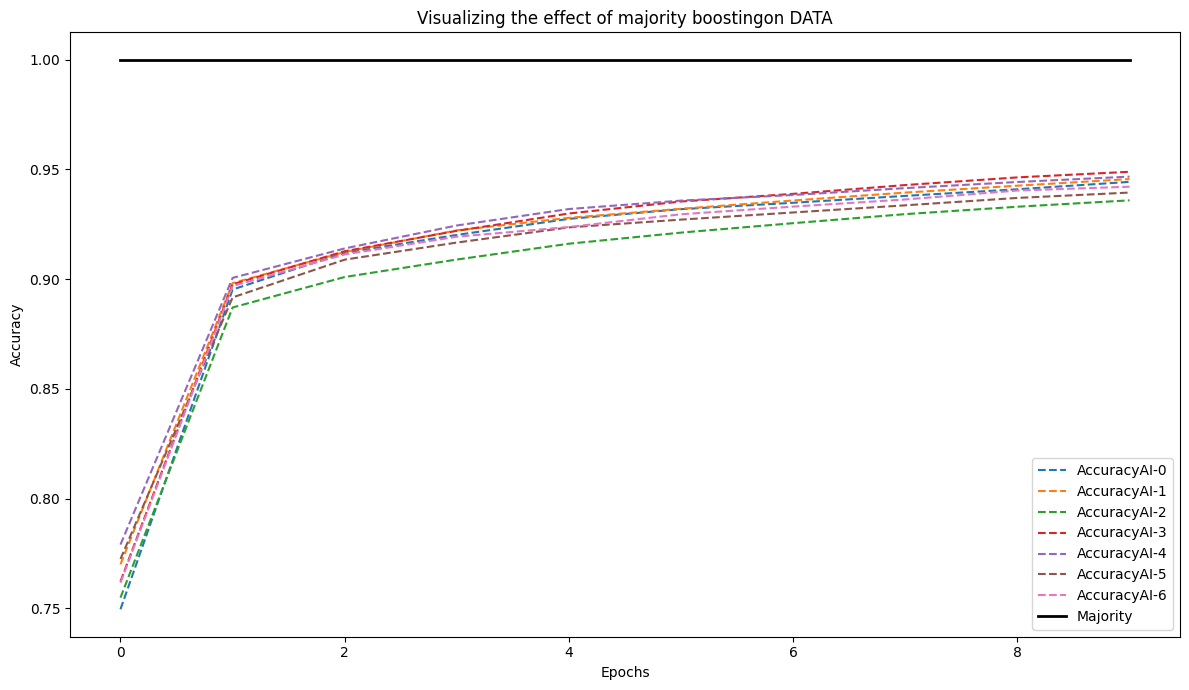

In [23]:
plt.figure(figsize=(12, 7))
# Tracer les précisions
for i in range(K):
    plt.plot(df.index, df[f'accuracyAI-{i}'], label=f'AccuracyAI-{i}', linestyle='--')

# Tracer la précision majoritaire
plt.plot(df.index, df['majority'], label='Majority', color='black', linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Visualizing the effect of majority boostingon DATA')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"majority_boosting_fashion_mnist.pdf", dpi=300, bbox_inches="tight")
plt.show()

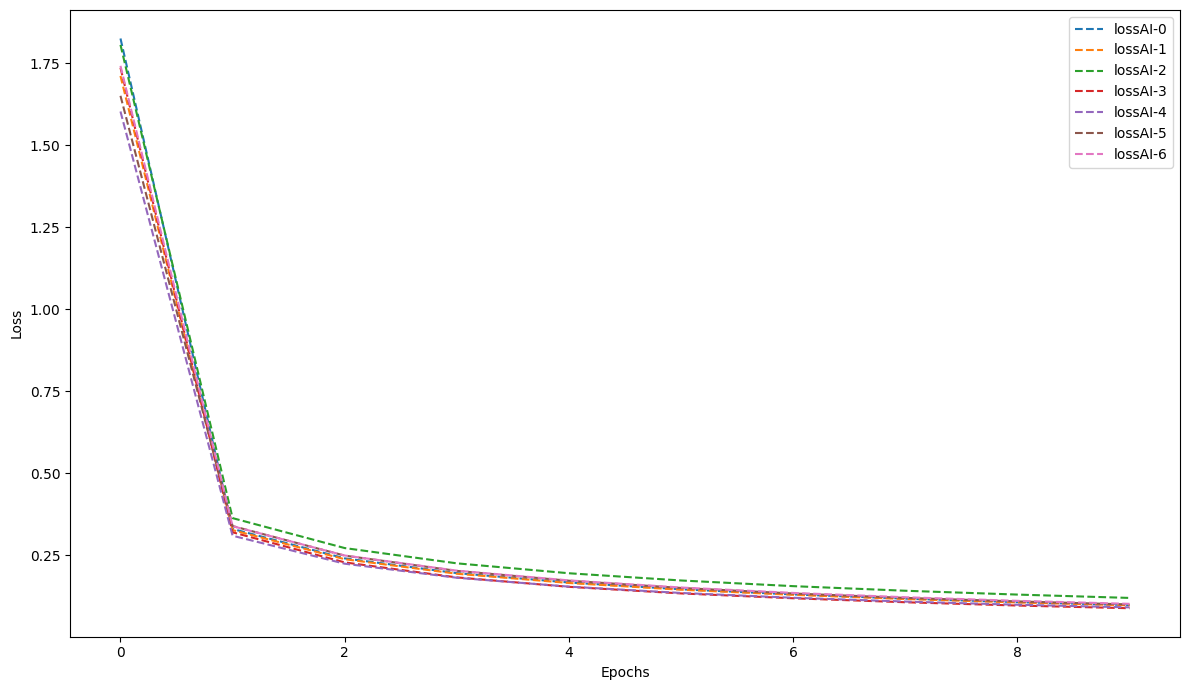

In [24]:
plt.figure(figsize=(12, 7))
# Tracer les précisions
for i in range(K):
    plt.plot(df.index, df[f'lossAI-{i}'], label=f'lossAI-{i}', linestyle='--')


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig(f"majoprity_boosting_losses.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [25]:
try:
    with open("historique.json", "w") as f:
        json.dump(json_, f, indent=4)
except Exception as e:
    print(f"Erreur lors de l'écriture du fichier JSON: {e}")


```TRAIN STANDARD```